# **Library Import and Setup**

In [12]:
# Import necessary libraries
import os
import random
import shutil
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten,Dropout
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# **Data Preparation and Preprocessing**

In [2]:
!wget https://zenodo.org/record/7869954/files/products_leaflets_256.zip
!unzip products_leaflets_256.zip
!wget https://github.com/ricocf/Product-Classification-on-Leaflet-Advertisements/raw/main/Data/image_model/trained_model.zip
!unzip trained_model.zip
model=tf.keras.models.load_model('/content/trained_model')

Streaming output truncated to the last 5000 lines.
  inflating: products_leaflets_256/train/738/39037.jpg  
  inflating: products_leaflets_256/train/738/39038.jpg  
  inflating: products_leaflets_256/train/738/39040.jpg  
  inflating: products_leaflets_256/train/738/39041.jpg  
  inflating: products_leaflets_256/train/738/39042.jpg  
  inflating: products_leaflets_256/train/738/39043.jpg  
  inflating: products_leaflets_256/train/738/39050.jpg  
  inflating: products_leaflets_256/train/738/39051.jpg  
  inflating: products_leaflets_256/train/738/39052.jpg  
  inflating: products_leaflets_256/train/738/39053.jpg  
  inflating: products_leaflets_256/train/738/39054.jpg  
  inflating: products_leaflets_256/train/738/39055.jpg  
  inflating: products_leaflets_256/train/738/39056.jpg  
  inflating: products_leaflets_256/train/738/39057.jpg  
  inflating: products_leaflets_256/train/738/39058.jpg  
  inflating: products_leaflets_256/train/738/39059.jpg  
  inflating: products_leaflets_256/tr

**Data Preparation: Test Dataset and CSV Mapping**

In [4]:
# Path to the root directory containing the class folders (0-831)
root_directory = '/content/products_leaflets_256/test'

csv_filename = 'test_class_mapping.csv'
with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Image_Name', 'Class_Name'])

    for class_folder in os.listdir(root_directory):
        class_path = os.path.join(root_directory, class_folder)
        if os.path.isdir(class_path):
            class_ = os.path.basename(class_path)
        for image_name in os.listdir(class_path):
          csv_writer.writerow([image_name,class_])

test_folder = '/content/products_leaflets_256/test'
new_folder = '/content/products_leaflets_256/test_temp'

if not os.path.exists(new_folder):
    os.makedirs(new_folder)
for subfolder in os.listdir(test_folder):
    subfolder_path = os.path.join(test_folder, subfolder)
    if os.path.isdir(subfolder_path):
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)
            shutil.move(file_path, new_folder)
for subfolder in os.listdir(test_folder):
    subfolder_path = os.path.join(test_folder, subfolder)
    if os.path.isdir(subfolder_path):
        os.rmdir(subfolder_path)

csv_test='/content/test_class_mapping.csv'
df_test = pd.read_csv(csv_test)


# **Data Augmentation and Preprocessing**

*   Generators for Test Images



In [5]:
# Define parameters for data augmentation and normalization
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

batch_size = 32
target_size = (224, 224)

test_image_dir = '/content/products_leaflets_256/test_temp'
test_temp_dir='/content/testaug'
if not os.path.exists(test_temp_dir):
  os.makedirs(test_temp_dir)

test_generator = datagen.flow_from_dataframe(
    df_test,  # DataFrame for training data
    directory=test_image_dir,
    x_col='Image_Name',
    y_col='Class_Name',
    target_size=target_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    save_to_dir=test_temp_dir,
    save_prefix='aug_train',
    save_format='jpeg'
)

Found 8320 validated image filenames.


# **Model Prediction and Evaluation**

In [6]:
predictions = model.predict(test_generator)
csv_file_path = '/content/test_class_mapping.csv'
true_labels_df = pd.read_csv(csv_file_path)
true_labels = true_labels_df['Class_Name'].values
image_names =true_labels_df['Image_Name']

260/260 [==============================] - 47s 157ms/step


# **Results Analysis and Visualization**

**Predictions Analysis and Results Export**

In [7]:
image_names = true_labels_df['Image_Name']

# Get the indices of the top 5 predictions
top5_predictions_indices = np.argsort(predictions, axis=1)[:, -5:] - 831
top5_classes = np.abs(top5_predictions_indices)
result_df = pd.DataFrame({
    'Image_Name': image_names,
    'Top1_Predicted_Class': top5_classes[:, 0],
    'Top2_Predicted_Class': top5_classes[:, 1],
    'Top3_Predicted_Class': top5_classes[:, 2],
    'Top4_Predicted_Class': top5_classes[:, 3],
    'Top5_Predicted_Class': top5_classes[:, 4],
})

# Include corresponding probabilities for the top 5 predictions
for i in range(1, 6):
    result_df[f'Top{i}_Probability'] = predictions[np.arange(len(predictions)), top5_predictions_indices[:, i - 1]]
result_df.to_csv('predictions_with_image_names_and_probabilities.csv', index=False)
print("Results with image names, top 5 predicted classes, and probabilities have been written to 'predictions_with_image_names_and_probabilities.csv'")

is_true_label_in_top5 = np.any(top5_classes == true_labels[:, np.newaxis], axis=1)
top5_accuracy = np.mean(is_true_label_in_top5)
print(top5_accuracy)

260/260 [==============================] - 43s 166ms/step
Results with image names, top 5 predicted classes, and probabilities have been written to 'predictions_with_image_names_and_probabilities.csv'
0.9703125


**Misclassification Analysis and Misclassified Images Identification**

In [8]:
import pandas as pd
import numpy as np

true_labels = df_test['Class_Name'].values
predicted_labels = abs(np.argmax(predictions, axis=1) - 831)
misclassified_indices = np.where(predicted_labels != true_labels)[0]
misclassified_image_names = df_test['Image_Name'].iloc[misclassified_indices].tolist()
misclassified_df = pd.DataFrame({'Misclassified Image Names': misclassified_image_names})
misclassified_df.to_csv('misclassified_images.csv', index=False)
predicted_labels = abs(np.argmax(predictions, axis=1) - 831)
misclassified_indices = np.where(predicted_labels != true_labels)[0]
max_probs_misclassified = np.max(predictions[misclassified_indices], axis=1)
result_df = pd.DataFrame({
    'True_Label': true_labels[misclassified_indices],
    'Predicted_Label': predicted_labels[misclassified_indices],
    'Max_Probability': max_probs_misclassified
})

# Save the results to a CSV file
result_df.to_csv('max_probability_for_misclassified.csv', index=False)

print("Results have been written to 'misclassified_images.csv' and 'max_probability_for_misclassified.csv'")
print(len(misclassified_indices))

Results have been written to 'misclassified_images.csv' and 'max_probability_for_misclassified.csv'
699


**Predicted Probabilities Distribution Analysis and Visualization**

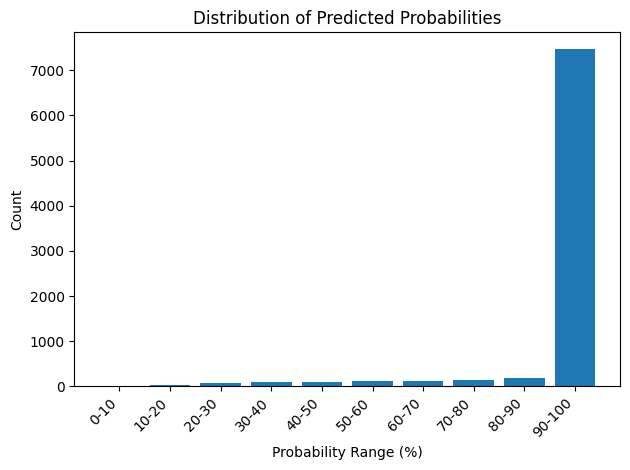

In [9]:
true_labels = true_labels_df['Class_Name'].values
predicted_labels = np.argmax(predictions, axis=1)
max_probs = np.max(predictions, axis=1)
bins = np.arange(0, 1.1, 0.1)

# Create the histogram
hist, edges = np.histogram(max_probs, bins=bins)
histogram_df = pd.DataFrame({
    'Probability_Range': [f'{int(start)}-{int(end)}' for start, end in zip(edges[:-1] * 100, edges[1:] * 100)],
    'Count': hist
})

# Save the histogram results to a CSV file
histogram_df.to_csv('probability_distribution_histogram.csv', index=False)

# Plot the histogram
plt.bar(histogram_df['Probability_Range'], histogram_df['Count'])
plt.xlabel('Probability Range (%)')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Misclassified Probabilities Distribution Analysis and Visualization**

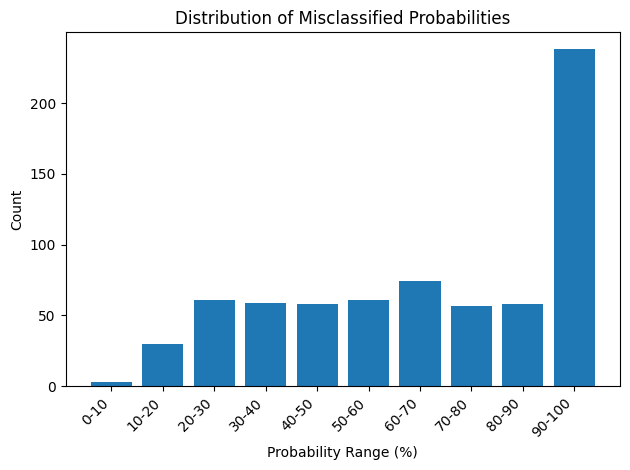

In [10]:
hist, edges = np.histogram(max_probs_misclassified, bins=bins)

# Create a DataFrame to store the histogram results
histogram_df = pd.DataFrame({
    'Probability_Range': [f'{int(start * 100)}-{int(end * 100)}' for start, end in zip(edges[:-1], edges[1:])],
    'Count': hist
})

# Save the histogram results to a CSV file
histogram_df.to_csv('misclassified_probability_histogram.csv', index=False)

# Plot the histogram
plt.bar(histogram_df['Probability_Range'], histogram_df['Count'])
plt.xlabel('Probability Range (%)')
plt.ylabel('Count')
plt.title('Distribution of Misclassified Probabilities')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Confusion Matrix Visualization**

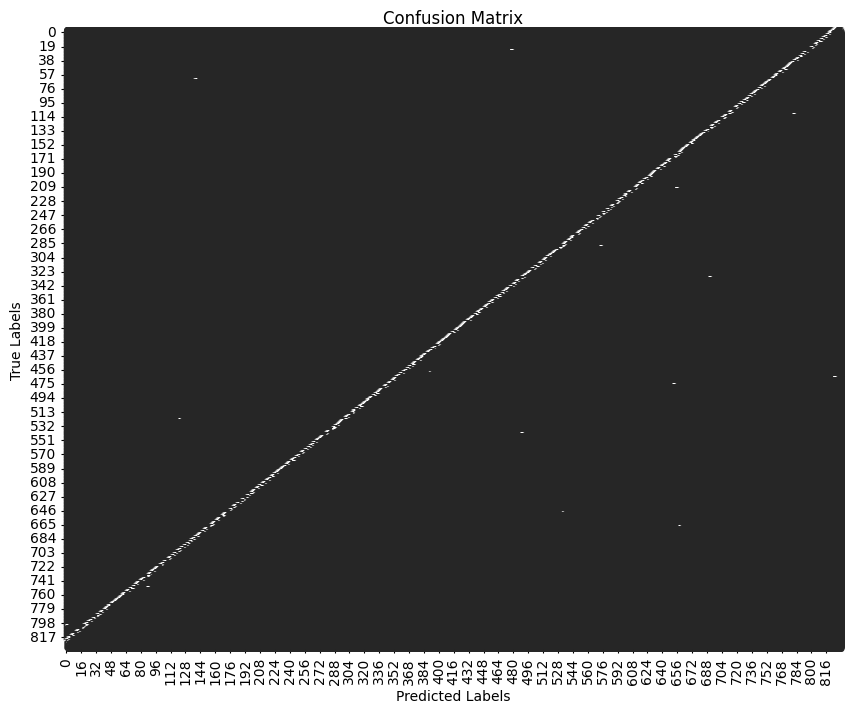

In [21]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
